# T5 TPU Tensorflow 

In [1]:
%tensorflow_version 2.x
!pip install transformers
!pip install sentencepiece

     |████████████████████████████████| 2.0MB 6.9MB/s 
     |████████████████████████████████| 3.3MB 20.5MB/s 
     |████████████████████████████████| 870kB 39.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=7cea5fbfddb8c5d8d9c99c33b3f45add9d0c7770ea41d6a9a947542e3fc4cc60
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses
     |████████████████████████████████| 1.2MB 6.8MB/s 


### Imports

We'll only be importing the components that we'll use during this tutorial: the TensorFlow model alongside the model specific tokenizer. The last two imports will manage the pre-processing of our data.

In [2]:
import tensorflow as tf
print(tf.__version__)

import os
from transformers import ( 
    T5Tokenizer, 
    TFT5Model, 
    TFT5ForConditionalGeneration
)

2.4.1


In [3]:
learning_rate = 3e-5

model_size = "t5-base"

BATCH_SIZE_PER_REPLICA = 6

EPOCHS = 10

MAX_ARTICLE_LEN = 512

MAX_HIGHLIGHT_LEN = 150

# Building the training system

## Strategy

We make use of TensorFlow's strategies, which handle the data distribution as well as the distributed training that happens on the devices available. In this example we'll be using a `MirroredStrategy` which can be used to train on a multiple GPUs in a distributed manner. 

In [4]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


INFO:tensorflow:Initializing the TPU system: grpc://10.30.221.10:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.30.221.10:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


In [5]:
strategy = tf.distribute.experimental.TPUStrategy(tpu)
print("Number of accelerators: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Number of accelerators:  8


## Loading the Dataset with the strategy

Here we define a batch size for each replica. We set it to be a multiple of 8 to best leverage the systolic array as defined in the [Google TPU performance guide](https://cloud.google.com/tpu/docs/performance-guide#rule_of_thumb_pick_efficient_values_for_batch_and_feature_dimensions).

In [6]:
GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
GLOBAL_BATCH_SIZE

48

### Retrieving the TFRecord dataset

The TFRecord dataset is now entirely processed and ready to be used as input by our training loop. We load it, shuffle it and batch it.

In [7]:
tokenizer = T5Tokenizer.from_pretrained(model_size)
en_de_prefix = tf.reshape(tokenizer("summarize English to German:", return_tensors="tf").input_ids, (-1,))
de_en_prefix = tf.reshape(tokenizer("summarize German to English: ", return_tensors="tf").input_ids, (-1,))
en_en_prefix = tf.reshape(tokenizer("summarize English to English: ", return_tensors="tf").input_ids, (-1,))
de_de_prefix = tf.reshape(tokenizer("summarize German to German: ", return_tensors="tf").input_ids, (-1,))
trans_en_de_prefix = tf.reshape(tokenizer("translate English to German: ", return_tensors="tf").input_ids, (-1,))
trans_de_en_prefix = tf.reshape(tokenizer("translate German to English: ", return_tensors="tf").input_ids, (-1,))

In [8]:
if en_de_prefix[-1] == 1: 
    en_de_prefix = en_de_prefix[:-1]
    de_en_prefix = de_en_prefix[:-1]
    en_en_prefix = en_en_prefix[:-1]
    de_de_prefix = de_de_prefix[:-1]


In [9]:
prefix_size = en_de_prefix.shape[0]
assert en_de_prefix.shape[0] == de_en_prefix.shape[0] == en_en_prefix.shape[0] == de_de_prefix.shape[0] == 5
prefix_size

5

In [10]:
en_de_prefix.numpy()

array([21603,  1566,    12,  2968,    10], dtype=int32)

In [12]:
from google.colab import auth
auth.authenticate_user()

# https://cloud.google.com/resource-manager/docs/creating-managing-projects
project_id = 'theta-strata-260123'
!gcloud config set project {project_id}

Updated property [core/project].


In [13]:
import numpy as np

bucket = "gs://tpu-bucket-cnn-daily-mail"

def listdir_gcp(directory):
    list_dir = !gsutil ls -r {directory}
    return list_dir

def get_tf_record_files(directory):
    file_list = []
    for item in listdir_gcp(directory):
        if item.split(".")[-1] == "tfrecord":
            file_list.append(str(item))
    return file_list

def get_tfrecord_dataset(directory):
    features = {
        'ger_x': tf.io.FixedLenFeature([MAX_ARTICLE_LEN-prefix_size], tf.int64),
        'ger_x_mask': tf.io.FixedLenFeature([MAX_ARTICLE_LEN-prefix_size], tf.int64),
        'ger_y': tf.io.FixedLenFeature([MAX_HIGHLIGHT_LEN], tf.int64),
        'ger_y_ids': tf.io.FixedLenFeature([MAX_HIGHLIGHT_LEN], tf.int64),

        'en_x': tf.io.FixedLenFeature([MAX_ARTICLE_LEN-prefix_size], tf.int64),
        'en_x_mask': tf.io.FixedLenFeature([MAX_ARTICLE_LEN-prefix_size], tf.int64),
        'en_y': tf.io.FixedLenFeature([MAX_HIGHLIGHT_LEN], tf.int64),
        'en_y_ids': tf.io.FixedLenFeature([MAX_HIGHLIGHT_LEN], tf.int64),
    }

    tf_records_list = get_tf_record_files(directory)
    print(tf_records_list)
    dataset = tf.data.TFRecordDataset(tf_records_list)

    # Taken from the TensorFlow models repository: https://github.com/tensorflow/models/blob/befbe0f9fe02d6bc1efb1c462689d069dae23af1/official/nlp/bert/input_pipeline.py#L24
    def decode_record(record, features):
        """Decodes a record to a TensorFlow example."""
        example = tf.io.parse_single_example(record, features)

        # tf.Example only supports tf.int64, but the TPU only supports tf.int32.
        # So cast all int64 to int32.
        for name in list(example.keys()):
            t = example[name]
            if t.dtype == tf.int64:
                t = tf.cast(t, tf.int32)
            example[name] = t
        return example


    def select_data_from_record(record):
        i  = tf.random.uniform((1,),0,4,dtype=tf.int32)[0]
        
        if i == 0:
            return tf.concat([de_de_prefix, record['ger_x']], axis=0), tf.concat([tf.ones(prefix_size, dtype=tf.int32), record['ger_x_mask']], axis=0), record['ger_y'], record['ger_y_ids']
        elif i == 1:
            return tf.concat([en_de_prefix, record['en_x']], axis=0), tf.concat([tf.ones(prefix_size, dtype=tf.int32), record['en_x_mask']], axis=0), record['ger_y'], record['ger_y_ids']
        elif i == 2:
            return tf.concat([de_en_prefix, record['ger_x']], axis=0), tf.concat([tf.ones(prefix_size, dtype=tf.int32), record['ger_x_mask']], axis=0), record['en_y'], record['en_y_ids']
        else:
            return tf.concat([en_en_prefix, record['en_x']], axis=0), tf.concat([tf.ones(prefix_size, dtype=tf.int32), record['en_x_mask']], axis=0), record['en_y'], record['en_y_ids']

    dataset = dataset.map(lambda record: decode_record(record, features))
    dataset = dataset.map(select_data_from_record)
    dataset = dataset.shuffle(500000)
    return dataset.batch(GLOBAL_BATCH_SIZE)



train_dataset = get_tfrecord_dataset(bucket + "/data/sueddeutsche_train/")
train_dataset.prefetch(1024)

validation_dataset = get_tfrecord_dataset(bucket + "/data/sueddeutsche_val/")
# test_dataset = get_tfrecord_dataset(bucket + "/data/sueddeutsche_val/")


['gs://tpu-bucket-cnn-daily-mail/data/sueddeutsche_train/sueddeutsche_multilingual-0.tfrecord', 'gs://tpu-bucket-cnn-daily-mail/data/sueddeutsche_train/sueddeutsche_multilingual-1.tfrecord', 'gs://tpu-bucket-cnn-daily-mail/data/sueddeutsche_train/sueddeutsche_multilingual-10.tfrecord', 'gs://tpu-bucket-cnn-daily-mail/data/sueddeutsche_train/sueddeutsche_multilingual-11.tfrecord', 'gs://tpu-bucket-cnn-daily-mail/data/sueddeutsche_train/sueddeutsche_multilingual-12.tfrecord', 'gs://tpu-bucket-cnn-daily-mail/data/sueddeutsche_train/sueddeutsche_multilingual-13.tfrecord', 'gs://tpu-bucket-cnn-daily-mail/data/sueddeutsche_train/sueddeutsche_multilingual-14.tfrecord', 'gs://tpu-bucket-cnn-daily-mail/data/sueddeutsche_train/sueddeutsche_multilingual-15.tfrecord', 'gs://tpu-bucket-cnn-daily-mail/data/sueddeutsche_train/sueddeutsche_multilingual-2.tfrecord', 'gs://tpu-bucket-cnn-daily-mail/data/sueddeutsche_train/sueddeutsche_multilingual-3.tfrecord', 'gs://tpu-bucket-cnn-daily-mail/data/suedde

In [14]:
train_dataset.take(1)

<TakeDataset shapes: ((None, 512), (None, 512), (None, 150), (None, 150)), types: (tf.int32, tf.int32, tf.int32, tf.int32)>

There is an additional step here to distribute the dataset among the different TPU cores. We make use of a strategy method to do so.

Every item held in the dataset (which is a batched dataset) will now be split over the TPU workers. As the TPU we're using has 8 workers and our batch is of size 64, every example will be evenly split in batches of (64 / 8 =) 8 and distributed across workers.

In [15]:
train_dist_dataset = strategy.experimental_distribute_dataset(train_dataset)
validation_dist_dataset = strategy.experimental_distribute_dataset(validation_dataset)

## Model creation

We create a function that will instantiate a new model when called.

In [16]:
def model_fn():
    return TFT5ForConditionalGeneration.from_pretrained(model_size, output_attentions=True)

## Hyperparameters initialization

While in the strategy's scope, we define a sparse categorical crossentropy loss. We define a method `compute_loss` which will be called to compute the loss between the model's prediction and the expected result (or label).

In order to measure the accuracy during training and evaluation, we define two metrics which are both sparse categorical accuracy.

Finally, we initialize a model and create an optimizer object using the Adam optimizer.


In [17]:
with strategy.scope():
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE, from_logits=True)

    def compute_loss(labels, predictions):
        per_example_loss = loss_object(labels, predictions)
        return tf.nn.compute_average_loss(per_example_loss, global_batch_size=GLOBAL_BATCH_SIZE)

    test_loss_metric = tf.keras.metrics.Mean(name='test_loss')
    test_accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

    train_loss_metric = tf.keras.metrics.Mean('training_loss', dtype=tf.float32)
    train_accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy('training_accuracy')
    
    model = model_fn()
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08)

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at t5-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


## Steps

We create two functions that will be called during the training and test steps. 

In [18]:
with strategy.scope():
    def train_step(inputs):
        input_ids, input_mask, y, y_ids = inputs

        with tf.GradientTape() as tape:
            logits = model(input_ids, attention_mask=input_mask, decoder_input_ids=y_ids, training=True)[0]             
            loss = compute_loss(y, logits)

        gradients = tape.gradient(loss, model.trainable_variables)

        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        train_loss_metric.update_state(loss)
        train_accuracy_metric.update_state(y, logits)

    def test_step(inputs):
        input_ids, input_mask, y, y_ids = inputs

        logits = model(input_ids, attention_mask=input_mask, decoder_input_ids=y_ids, training=False)[0]  
        t_loss = compute_loss(y, logits)

        test_loss_metric.update_state(t_loss)
        test_accuracy_metric.update_state(y, logits)

## Training & Evaluation

Finally, using all the previously defined attributes, we create two traced tf.function which will execute the training and test steps in a distributed manner. There is no need for them to return anything as the metrics will directly be updated in the steps described beforehand.

We loop over the number of epochs, training the model and evaluating it at the end of each epoch.

In [19]:
from tqdm.notebook import tqdm

def save_checkpoint(filename, epoch):
    ckpt_file = os.path.join(bucket, "{}/t5_base-{}.ckpt".format(filename, epoch))
    model.save_weights(ckpt_file) 

training_loss_list = []
validation_loss_list = []


with strategy.scope():
    @tf.function
    def distributed_train_step(dataset):
        strategy.run(train_step, args=(dataset,))
 

    @tf.function
    def distributed_test_step(dataset):
        strategy.run(test_step, args=(dataset,))


    global_step = 0
    for epoch in range(EPOCHS):
        total_loss = 0.0
        training_steps = 10
        epoch_step = 0
        print_every = 1000

        ### Training loop ###
        for tensor in tqdm(train_dist_dataset, desc="Training"):
            distributed_train_step(tensor)  

            train_loss = train_loss_metric.result().numpy().astype(float)
            train_accuracy = train_accuracy_metric.result().numpy()

            global_step += 1
            epoch_step += 1
            training_loss_list.append(train_loss)
            if epoch_step % print_every == 0:
                print(f"Training step {epoch_step} Training loss: {train_loss}")


        ### Test loop ###
        for tensor in tqdm(validation_dist_dataset, desc="Evaluating"):
            distributed_test_step(tensor)
            
        
        ### Output results ###
        val_accuracy = test_accuracy_metric.result().numpy()
        val_loss = test_loss_metric.result().numpy().astype(float)
        print(f'Epoch: [{epoch}] Validation loss = {val_loss}')
        validation_loss_list.append(val_loss)

        ### Reset metrics ###
        test_loss_metric.reset_states()
        train_accuracy_metric.reset_states()
        train_loss_metric.reset_states()
        test_accuracy_metric.reset_states()
        epoch_step = 0

        ### savecheckpoint ###
        save_checkpoint("t5_sueddeutsche", epoch)
        


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Training step 1000 Training loss: 13.289100646972656
Training step 2000 Training loss: 10.99670124053955
Training step 3000 Training loss: 10.092193603515625
Training step 4000 Training loss: 9.572710037231445



Epoch: [0] Validation loss = 9.136810302734375


Training step 1000 Training loss: 7.760985851287842
Training step 2000 Training loss: 7.726761341094971
Training step 3000 Training loss: 7.66487455368042
Training step 4000 Training loss: 7.613144874572754




Epoch: [1] Validation loss = 8.721479415893555


Training step 1000 Training loss: 7.318554878234863
Training step 2000 Training loss: 7.312159538269043
Training step 3000 Training loss: 7.285826683044434
Training step 4000 Training loss: 7.265405654907227




Epoch: [2] Validation loss = 8.586605072021484


Training step 1000 Training loss: 7.087429523468018
Training step 2000 Training loss: 7.0728631019592285
Training step 3000 Training loss: 7.0662407875061035
Training step 4000 Training loss: 7.05480432510376




Epoch: [3] Validation loss = 8.47606372833252


Training step 1000 Training loss: 6.97245454788208
Training step 2000 Training loss: 6.952075004577637
Training step 3000 Training loss: 6.930178165435791
Training step 4000 Training loss: 6.908130645751953




Epoch: [4] Validation loss = 8.338327407836914


Training step 1000 Training loss: 6.832931041717529
Training step 2000 Training loss: 6.7847371101379395
Training step 3000 Training loss: 6.78145170211792
Training step 4000 Training loss: 6.770649433135986




Epoch: [5] Validation loss = 8.25474739074707


Training step 1000 Training loss: 6.700423240661621
Training step 2000 Training loss: 6.700794696807861
Training step 3000 Training loss: 6.681453227996826
Training step 4000 Training loss: 6.673819065093994




Epoch: [6] Validation loss = 8.234540939331055


Training step 1000 Training loss: 6.594395637512207
Training step 2000 Training loss: 6.595091819763184
Training step 3000 Training loss: 6.5738677978515625
Training step 4000 Training loss: 6.568502426147461




Epoch: [7] Validation loss = 8.15027141571045


Training step 1000 Training loss: 6.505455493927002
Training step 2000 Training loss: 6.486947059631348
Training step 3000 Training loss: 6.491954326629639
Training step 4000 Training loss: 6.48913049697876




Epoch: [8] Validation loss = 8.081644058227539


Training step 1000 Training loss: 6.396988391876221
Training step 2000 Training loss: 6.4026031494140625
Training step 3000 Training loss: 6.410921096801758
Training step 4000 Training loss: 6.4133100509643555




Epoch: [9] Validation loss = 8.0833158493042


In [20]:
training_loss_list

[200.6690673828125,
 197.35317993164062,
 194.8758544921875,
 194.87457275390625,
 192.47267150878906,
 186.6013946533203,
 181.30691528320312,
 178.071044921875,
 174.40939331054688,
 169.17141723632812,
 165.34107971191406,
 160.35719299316406,
 156.24307250976562,
 152.34071350097656,
 148.55406188964844,
 145.39418029785156,
 141.6829376220703,
 137.37725830078125,
 133.2572021484375,
 129.18984985351562,
 125.2111587524414,
 121.45809936523438,
 117.76074981689453,
 114.48902130126953,
 111.3329849243164,
 108.42251586914062,
 105.62059783935547,
 103.074462890625,
 100.55789184570312,
 98.1622085571289,
 95.98434448242188,
 93.7862548828125,
 91.7550048828125,
 89.7953109741211,
 87.96795654296875,
 86.21463012695312,
 84.57120513916016,
 82.99853515625,
 81.52886199951172,
 80.02687072753906,
 78.62852478027344,
 77.24340057373047,
 75.92950439453125,
 74.61556243896484,
 73.43251037597656,
 72.2052993774414,
 71.08552551269531,
 70.05320739746094,
 69.01477813720703,
 67.986724

In [21]:
validation_loss_list

[9.136810302734375,
 8.721479415893555,
 8.586605072021484,
 8.47606372833252,
 8.338327407836914,
 8.25474739074707,
 8.234540939331055,
 8.15027141571045,
 8.081644058227539,
 8.0833158493042]

In [22]:
len(training_loss_list)

46020

In [23]:
np.arange(int(len(training_loss_list)/len(validation_loss_list)), len(training_loss_list)+1, int(len(training_loss_list)/len(validation_loss_list)))

array([ 4602,  9204, 13806, 18408, 23010, 27612, 32214, 36816, 41418,
       46020])

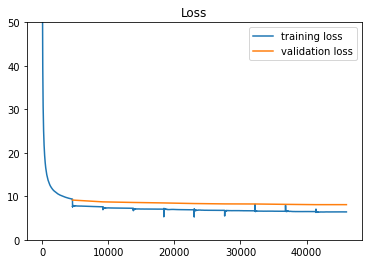

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.title("Loss")
plt.plot(training_loss_list, label = "training loss")
plt.plot(np.arange(int(len(training_loss_list)/len(validation_loss_list)), len(training_loss_list)+1, int(len(training_loss_list)/len(validation_loss_list))), validation_loss_list, label = "validation loss")
plt.ylim(0,50)
plt.legend()
plt.show()